In [1]:
%matplotlib inline

import cython
import gensim
import json, os, re
import matplotlib.pyplot as plt
import nltk.data
import numpy as np
import pickle
import random

from collections import defaultdict
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.models.word2vec import LineSentence
from nltk.tokenize import word_tokenize
from pathlib import Path
from sklearn.manifold import TSNE

In [2]:
DATA_DIR = str(Path().resolve().parent / "data" / "json")
TOKENIZER = nltk.data.load("tokenizers/punkt/polish.pickle")

def clear_text(content):
    remove_breaks    = re.sub(r"-\n",        "",  content)
    remove_linefeeds = re.sub(r"\n",         " ", remove_breaks)
    remove_tags      = re.sub(r"<[^>]*>",    " ", remove_linefeeds)
    remove_ellipsis  = re.sub(r"\(\.\.\.\)", "",  remove_tags)
    flatten_spaces   = re.sub(r"\s+",        " ", remove_ellipsis)
    return flatten_spaces

def judgment_year(judgment): return int(judgment['judgmentDate'][:4])

def sentences_with_stats(dirname, out_file, at_least_MiB):
    files = [f for f in os.listdir(dirname) if f.startswith("judgments-")]
    random.shuffle(files)
    at_least_bytes = int(at_least_MiB * 1024 * 1024)

    total_bytes = 0
    judgments_from_years = defaultdict(int, {})

    for filename in files:
        data = json.load(open(os.path.join(dirname, filename)))
        for judgment in data["items"]:
            cleared = clear_text(judgment["textContent"])
            sent_tokenized = TOKENIZER.tokenize(cleared)

            total_bytes += len(cleared.encode("utf-8"))
            year = judgment_year(judgment)
            judgments_from_years[year] += 1

            for sentence in sent_tokenized:
                word_tokenized = word_tokenize(sentence, language="polish")
                out_file.write(" ".join(word_tokenized) + "\n")

            if total_bytes >= at_least_bytes:
                return judgments_from_years, total_bytes / 1024 / 1024


with open("sentences.txt", "w") as out_file:
    JUDGMENTS_FROM_YEARS, TOTAL_MiB = sentences_with_stats(DATA_DIR, out_file, at_least_MiB=1536)

TOTAL_MiB

1536.0025520324707

In [3]:
dict(JUDGMENTS_FROM_YEARS)

{2015: 14763,
 2013: 10466,
 2016: 14479,
 2009: 1100,
 2017: 11728,
 2008: 1100,
 1998: 400,
 2014: 13500,
 2005: 500,
 2010: 1200,
 1995: 100,
 2018: 481,
 2101: 1,
 3013: 1,
 2012: 3634,
 2011: 1100,
 2001: 400,
 1997: 200,
 2000: 200,
 1999: 500,
 2006: 400,
 2004: 416,
 2007: 600,
 2003: 284}

## Wykrywanie wyrażeń wielosegmentowych

In [2]:
SENTENCES = LineSentence("sentences.txt")

In [3]:
bigram  = Phraser(Phrases(SENTENCES))
trigram = Phraser(Phrases(bigram[SENTENCES]))

In [4]:
with open("trigrams.txt", "w") as f:
    for sentence in trigram[bigram[SENTENCES]]:
        f.write(" ".join(sentence) + "\n")

## Trenowanie modelu Word2Vec

In [2]:
TRIGRAMS = LineSentence("trigrams.txt")

In [3]:
model = Word2Vec(TRIGRAMS,
                 sg=0,     # CBOW
                 window=5,
                 size=300,
                 min_count=3,
                 workers=8)

model.wv.save("w2v_trained")

## Wytrenowany model

In [2]:
MODEL = KeyedVectors.load("w2v_trained")

In [3]:
def no_(item):
    return item.replace("_", " ")

def list_items(items, compute_subitems, format_item=lambda item: item):
    for i, item in enumerate(items):
        print("{}. {}".format(i + 1, no_(format_item(item))))
        for subitem in compute_subitems(item):
            print("    - {: <40} ({: <10})".format(no_(subitem[0]), subitem[1]))

### Trzy najbardziej podobne wyrażenia (słowa i zwroty) dla następujących wyrażeń

In [4]:
PHRASES = [
    "Sąd_Najwyższy",
    "Trybunał_Konstytucyjny",
    "kodeks_cywilny",
    "kpk",
    "sąd_rejonowy",
    "szkoda",
    "wypadek",
    "kolizja",
    "szkoda_majątkowa",
    "nieszczęście",
    "rozwód"
]

list_items(PHRASES, lambda phrase: MODEL.similar_by_word(phrase, topn=3))

1. Sąd Najwyższy
    - Sad Najwyższy                            (0.7533131837844849)
    - Naczelny Sąd Administracyjny             (0.7307427525520325)
    - Trybunał Konstytucyjny                   (0.6865128874778748)
2. Trybunał Konstytucyjny
    - Trybunał                                 (0.9186258316040039)
    - Naczelny Sąd Administracyjny             (0.7582785487174988)
    - Trybunał Sprawiedliwości                 (0.7368369698524475)
3. kodeks cywilny
    - Kodeks cywilny                           (0.778557538986206)
    - Kodeks Cywilny                           (0.7075644731521606)
    - prawo bankowe                            (0.68433678150177)
4. kpk
    - k.p.k.                                   (0.8480235934257507)
    - k.p.k                                    (0.8244296312332153)
    - KPK                                      (0.7706083059310913)
5. sąd rejonowy
    - sąd okręgowy                             (0.8976067304611206)
    - sąd meriti                   

### Wypadkowa operacji na słowach (5 najbliższych wyników)

In [5]:
EXPRESSIONS = [
    [["Sąd_Najwyższy", # +
      "konstytucja"],  # -
     ["kpc"]],

    [["pasażer",       # +
      "kobieta"],      # -
     ["mężczyzna"]],

    [["samochód",      # +
      "rzeka"],        # -
     ["droga"]],
]

def format_expr(expr):
    positive, negative = expr
    return " + ".join(positive) + " - " + " - ".join(negative)

list_items(EXPRESSIONS, lambda expr: MODEL.most_similar(expr[0], expr[1], topn=5), format_expr)

1. Sąd Najwyższy + konstytucja - kpc
    - Trybunał                                 (0.576114296913147)
    - Trybunał Konstytucyjny                   (0.5760270953178406)
    - Trybunał Sprawiedliwości                 (0.5699954628944397)
    - prawodawca                               (0.5670279264450073)
    - ustrojodawca                             (0.5662017464637756)
2. pasażer + kobieta - mężczyzna
    - pasażerka                                (0.6880789399147034)
    - kierująca                                (0.671674907207489)
    - piesza                                   (0.6674413681030273)
    - rowerzystka                              (0.6499797105789185)
    - kierująca pojazdem                       (0.6294318437576294)
3. samochód + rzeka - droga
    - samochód marki                           (0.6519384384155273)
    - samochód osobowy                         (0.6139577031135559)
    - motocykl                                 (0.6077161431312561)
    - ciągnik siodło

### Projekcja wektorów słów na płaszczyznę (przy pomocy algorytmu t-SNE)

In [6]:
PHRASES_FOR_TSNE = [
    "szkoda",
    "strata",
    "uszczerbek",
    "szkoda_majątkowa",
#    "uszczerbek_na_zdrowiu",  # not in dictionary
    "krzywda",
    "niesprawiedliwość",
    "nieszczęście"
]

VECTORS = [MODEL[phrase] for phrase in PHRASES_FOR_TSNE]
EMBEDDED = TSNE(n_components=2).fit_transform(VECTORS)

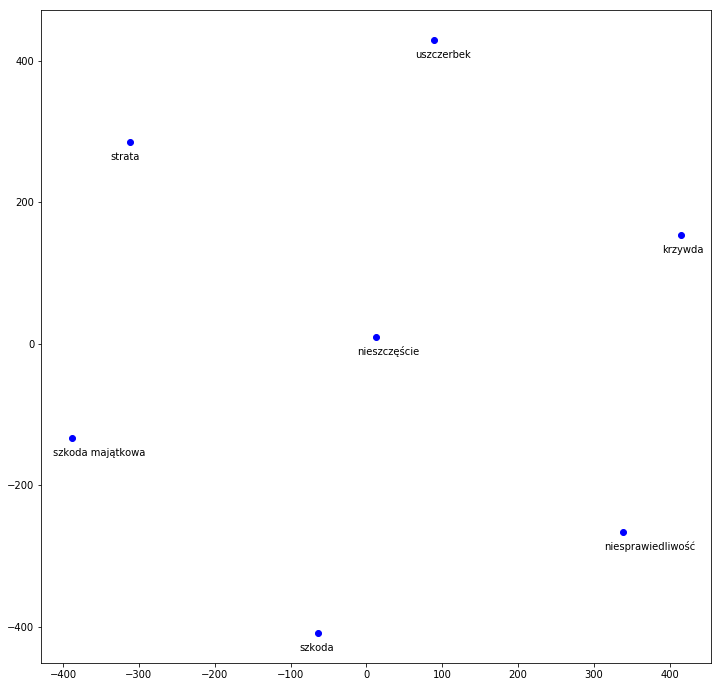

In [7]:
plt.figure(figsize=(12, 12))
plt.plot(EMBEDDED[:,0], EMBEDDED[:,1], "bo")

for label, (x, y) in zip(PHRASES_FOR_TSNE, EMBEDDED):
    plt.annotate(no_(label), (x, y), (x - 25, y - 25))

plt.show()